# AzureML Basics
This notebook includes an overview of accessing data, training a model, and registering/deploying a model

## Importing and installing libraries
Most common data and machine learning libraries are preinstalled such as pandas, numpy, scikit learn, pytorch, tensorflow, etc.

In [2]:
import pandas as pd
import numpy as np
from azureml.core import Datastore, Workspace, Dataset, Model
from  azureml.data.dataset_factory import TabularDatasetFactory
import joblib
from sklearn.linear_model import Ridge
from azureml.core.resource_configuration import ResourceConfiguration
import sklearn
import matplotlib.pyplot as plt

To install a different library, use the following:

This is intalling the transformers library from hugging face

In [ ]:
!pip install transformers

### Logon to AzureML Workspace

In [10]:
# Get AML Workspace

ws = Workspace.from_config()

### Accessing Data

In [31]:
# Register datastore

blob_datastore_name='trainingdata' # Name of the datastore to workspace
container_name='data' # Name of Azure blob container
account_name='serafinostorage' # Storage account name
account_key='' # Storage account access key

blob_datastore = Datastore.register_azure_blob_container(workspace=ws, 
                                                         datastore_name=blob_datastore_name, 
                                                         container_name=container_name, 
                                                         account_name=account_name,
                                                         account_key=account_key)

In [32]:
# Create Dataset and Register to workspace
dataset = TabularDatasetFactory.from_delimited_files(path=(blob_datastore,"diabetes_dataset.csv"))

dataset = dataset.register(workspace=ws,
                                 name='diabetes',
                                 description='diabetes training data', create_new_version=True)

### Consuming Data

In [34]:
# then simply use this code to get the handle to the dataset
diabetes = ws.datasets['diabetes']

# Get data in Pandas format and develop
df = dataset.to_pandas_dataframe()

### EDA and Transformations

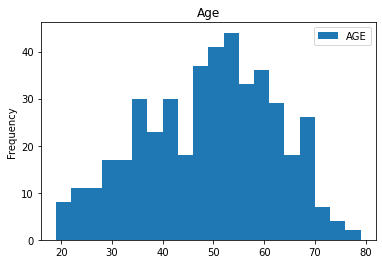

In [ ]:
df[['AGE']].plot.hist(bins=20,title='Age')

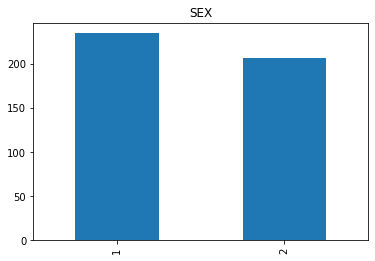

In [ ]:
df['SEX'].value_counts().plot.bar(title='SEX')

In [ ]:
corr = df[['AGE','BP','BMI','Y']].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,AGE,BP,BMI,Y
AGE,1,0.34,0.19,0.19
BP,0.34,1,0.4,0.44
BMI,0.19,0.4,1,0.59
Y,0.19,0.44,0.59,1


#### Register dataframe as a dataset
If you made any transformations to your data, you can optionally register your dataset again to save these changes. You may want to save it as a new name to not overwrite your raw dataset.

In [48]:
# Register dataset from pandas dataframe to save transformed dataset
dataset = Dataset.Tabular.register_pandas_dataframe(df, blob_datastore, "diabetes_1", show_progress=True)

Method register_pandas_dataframe: This is an experimental method, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to managed-dataset/5a31bd80-5e92-4ff9-b3e3-61dc7b8b5422/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.


### Modeling

In [50]:
# get dataset and split to x and y
diabetes = ws.datasets['diabetes']
X = diabetes.drop_columns("Y")
y = diabetes.keep_columns("Y")
X_df = X.to_pandas_dataframe()
y_df = y.to_pandas_dataframe()
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
AGE    442 non-null int64
SEX    442 non-null int64
BMI    442 non-null float64
BP     442 non-null float64
S1     442 non-null int64
S2     442 non-null float64
S3     442 non-null float64
S4     442 non-null float64
S5     442 non-null float64
S6     442 non-null int64
dtypes: float64(6), int64(4)
memory usage: 34.7 KB


#### Training

In [51]:
# train model and save output in pickle file

model = Ridge().fit(X_df,y_df)
joblib.dump(model, 'sklearn_regression_model.pkl')

['sklearn_regression_model.pkl']

#### Registering
Now that we saved our model, we can now use that file to register it so that we can use that to deploy it.

In [4]:
# register model to deploy

model = Model.register(workspace=ws,
                       model_name='my-sklearn-model',                # Name of the registered model in your workspace.
                       model_path='./sklearn_regression_model.pkl',  # Local file to upload and register as a model.
                       model_framework=Model.Framework.SCIKITLEARN,  # Framework used to create the model.
                       model_framework_version=sklearn.__version__,  # Version of scikit-learn used to create the model.
                       sample_input_dataset=X,
                       sample_output_dataset=y,
                       resource_configuration=ResourceConfiguration(cpu=2, memory_in_gb=4),
                       description='Ridge regression model to predict diabetes progression.',
                       tags={'area': 'diabetes', 'type': 'regression'})

print('Name:', model.name)
print('Version:', model.version)

Registering model my-sklearn-model
Name: my-sklearn-model
Version: 1


#### Deployment
Now that our model is registered, we can deploy it.

Step 1: Create score file

In [5]:
%%writefile score.py

import json
import pickle
import numpy as np
import pandas as pd
import os
import joblib
from azureml.core.model import Model

from inference_schema.schema_decorators import input_schema, output_schema
from inference_schema.parameter_types.numpy_parameter_type import NumpyParameterType
from inference_schema.parameter_types.pandas_parameter_type import PandasParameterType


def init():
    global model
    # Replace filename if needed.
    path = os.getenv('AZUREML_MODEL_DIR') 
    model_path = os.path.join(path, 'sklearn_regression_model.pkl')
    # Deserialize the model file back into a sklearn model.
    model = joblib.load(model_path)


input_sample = pd.DataFrame(data=[{
    "AGE": 5,
    "SEX": 2,
    "BMI": 3.1,
    "BP": 3.1,
    "S1": 3.1,
    "S2": 3.1,
    "S3": 3.1,
    "S4": 3.1,
    "S5": 3.1,
    "S6": 3.1
}])

# This is an integer type sample. Use the data type that reflects the expected result.
output_sample = np.array([0])

# To indicate that we support a variable length of data input,
# set enforce_shape=False
@input_schema('data', PandasParameterType(input_sample))
@output_schema(NumpyParameterType(output_sample))
def run(data):
    try:
        print("input_data....")
        print(data.columns)
        print(type(data))
        result = model.predict(data)
        print("result.....")
        print(result)
    # You can return any data type, as long as it can be serialized by JSON.
        return result.tolist()
    except Exception as e:
        error = str(e)
        return error

Writing score.py


Step 2: Define environment

In [7]:
from azureml.core.model import InferenceConfig
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

environment = Environment('my-sklearn-environment')
environment.python.conda_dependencies = CondaDependencies.create(pip_packages=[
    'azureml-defaults',
    'inference-schema[numpy-support]',
    'joblib',
    'numpy',
    'pandas',
    'scikit-learn=={}'.format(sklearn.__version__)
])

inference_config = InferenceConfig(entry_script='./score.py',environment=environment)

Step 3: Deploy

In [8]:
service_name = 'my-diabetes-model'

service = Model.deploy(ws, service_name, [model], inference_config, overwrite=True)
service.wait_for_deployment(show_output=True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2022-01-14 17:06:01+00:00 Creating Container Registry if not exists.
2022-01-14 17:06:01+00:00 Registering the environment.
2022-01-14 17:06:03+00:00 Building image..
2022-01-14 17:11:31+00:00 Generating deployment configuration.
2022-01-14 17:11:32+00:00 Submitting deployment to compute..
2022-01-14 17:11:36+00:00 Checking the status of deployment my-diabetes-model..
2022-01-14 17:14:00+00:00 Checking the status of inference endpoint my-diabetes-model.
Succeeded
ACI service creation operation finished, operation "Succeeded"


Step 4: Test deployment once succeded

In [9]:
# test deployment

import json

input_payload = json.dumps({
    'data': X_df[0:2].values.tolist()
})

output = service.run(input_payload)

print(output)

[[205.59094435613133], [68.84146418576978]]
